
Booth: 2D


In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 7.3 MB/s 
     |████████████████████████████████| 872 kB 4.9 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=a841ce992aec0cbd51a4a834bb34bcd0af87547d2cbd7ffdeb801de4c49c99fe
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=efbb0579c8f1fbe4d1c05d83ca26a8cb5b2a6d7d939906a22ec1c965c1251eac
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built pyGPGO Theano-PyMC


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import t
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'Booth'
n_test = 500
eps = 1e-08

util = 'EI'

n_init = 5 # random initialisations
iters = 20
opt = True

df = 3


In [4]:
### Objective Function - Booth(x) 2-D:

def objfunc(x1_training, x2_training):
            return  operator * ( (x1_training + 2 * x2_training -7) ** 2 +
                                 (2 * x1_training + x2_training -5) ** 2
                            )
        
# Constraints:
lb = -10
ub = +10
    
# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
                 'x2_training': ('cont', [lb, ub])
                 }
    
# True y bounds:
y_lb = 0
operator = -1 # targets global minimum 
y_global_orig = y_lb * operator # targets global minimum
    
# Test data:
x1_test = np.linspace(lb, ub, n_test)
x2_test = np.linspace(lb, ub, n_test)
x_test = np.column_stack((x1_test, x2_test))


In [5]:
n_start_AcqFunc = iters
inverse = -1


In [6]:
### Cumulative Regret Calculators:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  
def acqFuncExact(x):
    new_array = []
    x = np.array(x) * -1
    for i, num in enumerate(x):
            new_array = x[:-2][::-3]
    return new_array[::-1]

def acqFuncApprox(x):
    new_array = []
    x = np.array(x) * -1
    for i, num in enumerate(x):
            new_array = x[:-1][::-3]
    return new_array[::-1]


In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dtStudentProcess(tStudentProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the STP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        
        smd_adj = (self.nu + self.beta1 - 2) / (self.nu + self.n1 - 2)

        alpha = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), self.y)
        alpha_Kstar = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)      
        
        dm = np.dot(dKstar, alpha)
        ds = -2 * smd_adj * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds

In [8]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]
    
    def EI(self, tau, mean, std, ds, dm, nu=3.0):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * t.cdf(gamma, df=nu) + (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * (t.cdf(gamma, df=nu) * dmdx + gamma * t.pdf(gamma, df=nu) \
            * (1 - (nu + gamma ** 2)/(nu - 1) + 2/(nu - 1) * dmdx))
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm, nu=3.0):
    
        return self.f(tau, mean, std, ds, dm, nu=3.0, **self.params)
        

In [9]:
## GPGO_multi: 

n_start = n_start_AcqFunc

class GPGO_multi(GPGO):
    
    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Min. ExactAcqFunc \t Min. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

        x_best_exact = np.empty((n_start, len(self.parameter_key)))
        f_best_exact = np.empty((n_start,))
        opt_exact = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_exact = np.array([res.x for res in opt_exact])
        f_best_exact = np.array([np.atleast_1d(res.fun)[0] for res in opt_exact])
        f_best_min_exact = min(f_best_exact)

        self.x_best_exact = x_best_exact
        self.f_best_exact = f_best_exact
        self.f_best_min_exact = f_best_min_exact
        self.best_exact = x_best_exact[np.argmin(f_best_exact)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min_exact)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_exact = str(self.f_best_min_exact)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfunc = BOLD + OKGREEN + min_acqfunc + ENDC
            min_acqfunc_exact = BOLD + OKGREEN + min_acqfunc_exact + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfunc_exact, min_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO:

n_start = n_start_AcqFunc

class dGPGO(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Min. ExactAcqFunc \t Min. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B'):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min)

        x_best_approx = np.empty((n_start, len(self.parameter_key)))
        f_best_approx = np.empty((n_start,))
        opt_approx = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_approx = np.array([res.x for res in opt_approx])
        f_best_approx = np.array([np.atleast_1d(res.fun)[0] for res in opt_approx])
        f_best_min_approx = min(f_best_approx)

        self.x_best_approx = x_best_approx
        self.f_best_approx = f_best_approx
        self.f_best_min_approx = f_best_min_approx
        self.best_approx = x_best_approx[np.argmin(f_best_approx)]
        self.start_points_arr = start_points_arr
        self.history.append(self.f_best_min_approx)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_approx = str(self.f_best_min_approx)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfunc = BOLD + OKGREEN + min_acqfunc + ENDC
            min_acqfunc_approx = BOLD + OKGREEN + min_acqfunc_approx + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfunc, min_acqfunc_approx))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
###Reproducible set-seeds:

run_num_15 = 15


***Explanation:*** Why does optimising negative EI with exact (negative) EI gradients, outperform approximate (negative) EI gradients for (negative) EI optimisation?


1. Considering the best (**x**, *y*) point sampled by the exact (negative) EI gradients' model



In [12]:
### ESTIMATED STP EI GRADIENTS: 20 random-multi starts (i.e. 20 rms)

np.random.seed(run_num_15)
surrogate_approx_15 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_grad(util), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. ExactAcqFunc 	 Min. ApproxAcqFunc 
init	 [ 6.97635395 -6.4220815 ]	 171.98457986923216	 171.98457986923216	    	    
init	 [-8.91273571 -2.76923108]	 1115.2426864421157	 171.98457986923216	    	    
init	 [-4.49198143  0.6000045 ]	 285.0550378664367	 171.98457986923216	    	    
init	 [-3.88162169 -3.91051282]	 627.8031621427792	 171.98457986923216	    	    
init	 [-7.76517448 -5.00201972]	 1265.415808453521	 171.98457986923216	    	    
1  	 [2.89826636 8.33020007]	 241.01735544838436	 171.98457986923216	 -501.58589261051	 -501.58589261051


In [13]:
### EXACT STP EI GRADIENTS: 20 random-multi starts (i.e. 20 rms)

np.random.seed(run_num_15)
surrogate_exact_15 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_grad(util), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. ExactAcqFunc 	 Min. ApproxAcqFunc 
init	 [ 6.97635395 -6.4220815 ]	 171.98457986923216	 171.98457986923216	    	    
init	 [-8.91273571 -2.76923108]	 1115.2426864421157	 171.98457986923216	    	    
init	 [-4.49198143  0.6000045 ]	 285.0550378664367	 171.98457986923216	    	    
init	 [-3.88162169 -3.91051282]	 627.8031621427792	 171.98457986923216	    	    
init	 [-7.76517448 -5.00201972]	 1265.415808453521	 171.98457986923216	    	    
1	 [-1.08003705  9.49213271]	 124.34069392980017	 124.34069392980017	 -501.58589261051	 -501.58589261051


In [14]:
approx_15.start_points_arr


array([[ 8.90076834, -7.81106703],
       [-0.69813678, -7.1688948 ],
       [ 0.76697524, -4.02002687],
       [ 0.75490439,  3.31255076],
       [-2.71342399,  2.46037239],
       [ 2.8544977 , -1.6003636 ],
       [-1.93515132, -2.19159348],
       [-1.87620955, -8.40667789],
       [-8.86337597, -8.43338183],
       [ 3.91355621, -9.41682078],
       [-0.01015161, -7.34731365],
       [-9.38488733,  2.78978857],
       [-1.08003705,  9.49213271],
       [-3.40468135, -6.09150354],
       [ 3.68092425, -2.97802285],
       [ 5.42072227,  5.83599003],
       [-1.12250822, -4.62343397],
       [-9.52191156, -2.57334868],
       [-8.04538241,  4.55045097],
       [-0.81111149,  0.4099295 ]])

In [15]:
exact_15.start_points_arr


array([[ 8.90076834, -7.81106703],
       [-0.69813678, -7.1688948 ],
       [ 0.76697524, -4.02002687],
       [ 0.75490439,  3.31255076],
       [-2.71342399,  2.46037239],
       [ 2.8544977 , -1.6003636 ],
       [-1.93515132, -2.19159348],
       [-1.87620955, -8.40667789],
       [-8.86337597, -8.43338183],
       [ 3.91355621, -9.41682078],
       [-0.01015161, -7.34731365],
       [-9.38488733,  2.78978857],
       [-1.08003705,  9.49213271],
       [-3.40468135, -6.09150354],
       [ 3.68092425, -2.97802285],
       [ 5.42072227,  5.83599003],
       [-1.12250822, -4.62343397],
       [-9.52191156, -2.57334868],
       [-8.04538241,  4.55045097],
       [-0.81111149,  0.4099295 ]])

In [16]:
np.sum((exact_15.start_points_arr - approx_15.start_points_arr)**2)


0.0

In [17]:
np.round(approx_15.f_best, 5), np.argmin(approx_15.f_best)


(array([-501.58503, -501.58589, -501.58588, -501.58589, -501.58589,
        -501.58589, -501.58589, -501.58589, -501.58578, -501.58589,
        -501.58589, -501.58579, -501.58589, -501.58589, -501.58589,
        -501.58589, -501.58586, -501.58589, -501.58583, -501.58589]), 4)

In [18]:
min(approx_15.f_best), np.round(max(approx_15.f_best), 4)


(-501.58589261051, -501.585)

In [19]:
approx_15.x_best[np.argmin(approx_15.f_best)], approx_15.best


(array([2.89826636, 8.33020007]), array([2.89826636, 8.33020007]))

In [20]:
np.round(exact_15.f_best, 5), np.argmin(exact_15.f_best)


(array([-501.58578, -501.58018, -501.58219, -501.58589, -501.58578,
        -501.58589, -501.58578, -501.58489, -501.58578, -501.58068,
        -501.58561, -501.58579, -501.58589, -501.58578, -501.58531,
        -501.58589, -501.58578, -501.58589, -501.58583, -501.49223]), 12)

In [21]:
min(exact_15.f_best), np.round(max(exact_15.f_best), 4)


(-501.58589261051, -501.4922)

In [22]:
exact_15.x_best[np.argmin(exact_15.f_best)], exact_15.best


(array([-1.08003705,  9.49213271]), array([-1.08003705,  9.49213271]))

In [23]:
np.sum((exact_15.f_best - approx_15.f_best)**2)


0.008847985735470994

In [24]:
exact_15.x_best


array([[-10.        , -10.        ],
       [ -0.69813678,  -7.1688948 ],
       [  0.76697524,  -4.02002687],
       [  0.75490439,   3.31255076],
       [-10.        , -10.        ],
       [  2.8544977 ,  -1.6003636 ],
       [-10.        , -10.        ],
       [ -1.87620955,  -8.40667789],
       [-10.        , -10.        ],
       [  3.91355621,  -9.41682078],
       [ -0.01015161,  -7.34731365],
       [ -9.38488733,   2.78978857],
       [ -1.08003705,   9.49213271],
       [-10.        , -10.        ],
       [  3.68092425,  -2.97802285],
       [  5.42072227,   5.83599003],
       [-10.        , -10.        ],
       [  3.90115321,   6.07195602],
       [ -8.04538241,   4.55045097],
       [ -0.81111149,   0.4099295 ]])

In [25]:
np.sum((exact_15.x_best - exact_15.start_points_arr)**2)


1121.5566012870054

In [26]:
approx_15.x_best


array([[ 10.        , -10.        ],
       [  0.36508771,  -8.32137776],
       [  1.97618176,  -3.58180904],
       [  0.75492144,   3.31256213],
       [  2.89826636,   8.33020007],
       [  2.8544977 ,  -1.6003636 ],
       [ 10.        ,   8.55841796],
       [ -1.56208654,  -9.68605463],
       [-10.        , -10.        ],
       [  1.23439089, -10.        ],
       [  0.57481351,  -8.19757581],
       [ -9.38514881,   2.79020352],
       [ -1.08003705,   9.49213271],
       [  2.14800699, -10.        ],
       [  2.62118995,  -2.44641192],
       [  5.42072227,   5.83599003],
       [  1.61917491,  -5.37162334],
       [-10.        ,  10.        ],
       [ -8.04562115,   4.5506954 ],
       [  1.56797552,   0.29721486]])

In [27]:
np.sum((approx_15.x_best - approx_15.start_points_arr)**2)


567.7153631722961

In [28]:
np.sum((exact_15.x_best - approx_15.x_best)**2)


2180.959065281176

In [29]:
a = approx_15.best[0]
b = approx_15.best[1]

-objfunc(a, b) # negating before final print statement, as agreed with GH and SMcC


241.01735544838436

In [30]:
a = exact_15.best[0]
b = exact_15.best[1]

-objfunc(a, b) # negating before final print statement, as agreed with GH and SMcC


124.34069392980017

In [31]:
xBest0 = 0.0898
xBest1 = -0.7126

xBest = [xBest0, xBest1]
xBest


[0.0898, -0.7126]

In [32]:
def check(x):
  a = x[:,0]
  b = x[:,1] 
  for i in range(0, len(a) - 1):
    res = (a - xBest0)**2 + (b - xBest1)**2 
    return np.sum(res)

check(approx_15.x_best), check(exact_15.x_best)


(1684.7245851816692, 1857.997114986672)

In [33]:
np.std(approx_15.x_best), np.std(exact_15.x_best)


(6.519288465109335, 6.159928384414911)

In [34]:
np.mean(approx_15.x_best), np.mean(exact_15.x_best)


(-0.5518865989323465, -3.227212621015184)

In [35]:
approx_15_20rms = pd.Series(np.round(approx_15.f_best, 2)).value_counts(sort=True)
approx_15_20rms_df = pd.DataFrame({'Frequency':approx_15_20rms.values,'STP EI':approx_15_20rms.index})
approx_15_20rms_df


,Frequency,STP EI
0,20,-501.59


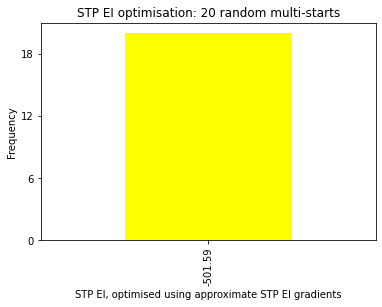

In [36]:
ax = approx_15_20rms.plot.bar(title="STP EI optimisation: 20 random multi-starts", xlabel="STP EI, optimised using approximate STP EI gradients", ylabel="Frequency", color="yellow", yticks=[0,6,12,18])


In [37]:
exact_15_20rms = pd.Series(np.round(exact_15.f_best, 2)).value_counts(sort=True)
exact_15_20rms_df = pd.DataFrame({'Frequency':exact_15_20rms.values,'STP EI':exact_15_20rms.index})
exact_15_20rms_df


,Frequency,STP EI
0,15,-501.59
1,4,-501.58
2,1,-501.49


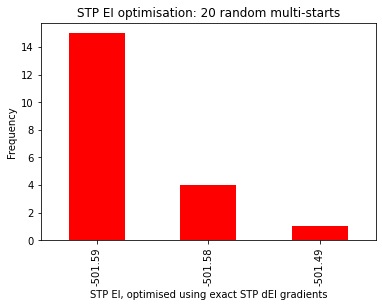

In [38]:
ax = exact_15_20rms.plot.bar(title="STP EI optimisation: 20 random multi-starts", xlabel="STP EI, optimised using exact STP dEI gradients", ylabel="Frequency", color="red")


In [39]:
n_start = 50


In [40]:
### ESTIMATED STP EI GRADIENTS: 50 random-multi starts (i.e. 50 rms)

np.random.seed(run_num_15)
surrogate_approx_15_50rms = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_15_50rms = GPGO_multi(surrogate_approx_15_50rms, Acquisition_grad(util), objfunc, param)
approx_15_50rms.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. ExactAcqFunc 	 Min. ApproxAcqFunc 
init	 [ 6.97635395 -6.4220815 ]	 171.98457986923216	 171.98457986923216	    	    
init	 [-8.91273571 -2.76923108]	 1115.2426864421157	 171.98457986923216	    	    
init	 [-4.49198143  0.6000045 ]	 285.0550378664367	 171.98457986923216	    	    
init	 [-3.88162169 -3.91051282]	 627.8031621427792	 171.98457986923216	    	    
init	 [-7.76517448 -5.00201972]	 1265.415808453521	 171.98457986923216	    	    
1  	 [2.89826636 8.33020007]	 241.01735544838436	 171.98457986923216	 -501.58589261051	 -501.58589261051


In [41]:
### EXACT STP EI GRADIENTS: 50 random-multi starts (i.e. 50 rms)

np.random.seed(run_num_15)
surrogate_exact_15_50rms = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_15_50rms = dGPGO(surrogate_exact_15_50rms, Acquisition_grad(util), objfunc, param)
exact_15_50rms.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. ExactAcqFunc 	 Min. ApproxAcqFunc 
init	 [ 6.97635395 -6.4220815 ]	 171.98457986923216	 171.98457986923216	    	    
init	 [-8.91273571 -2.76923108]	 1115.2426864421157	 171.98457986923216	    	    
init	 [-4.49198143  0.6000045 ]	 285.0550378664367	 171.98457986923216	    	    
init	 [-3.88162169 -3.91051282]	 627.8031621427792	 171.98457986923216	    	    
init	 [-7.76517448 -5.00201972]	 1265.415808453521	 171.98457986923216	    	    
1	 [-1.08003705  9.49213271]	 124.34069392980017	 124.34069392980017	 -501.58589261051	 -501.58589261051


In [42]:
approx_15_50rms = pd.Series(np.round(approx_15_50rms.f_best, 2)).value_counts(sort=True)
approx_15_50rms_df = pd.DataFrame({'Frequency':approx_15_50rms.values,'STP EI':approx_15_50rms.index})
approx_15_50rms_df


,Frequency,STP EI
0,50,-501.59


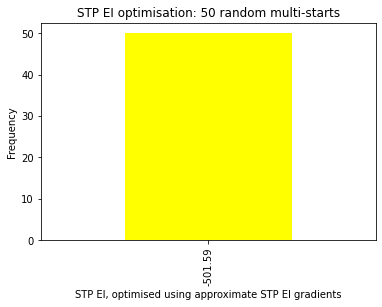

In [43]:
ax = approx_15_50rms.plot.bar(title="STP EI optimisation: 50 random multi-starts", xlabel="STP EI, optimised using approximate STP EI gradients", ylabel="Frequency", color="yellow")


In [44]:
exact_15_50rms = pd.Series(np.round(exact_15_50rms.f_best, 2)).value_counts(sort=True)
exact_15_50rms_df = pd.DataFrame({'Frequency':exact_15_50rms.values,'STP EI':exact_15_50rms.index})
exact_15_50rms_df


,Frequency,STP EI
0,40,-501.59
1,6,-501.58
2,1,-501.49
3,1,-486.72
4,1,-501.56
5,1,-486.97


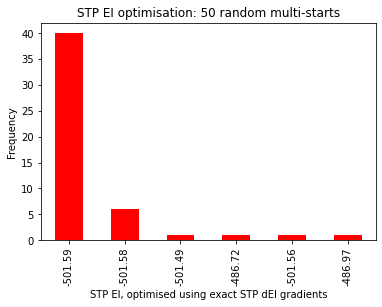

In [45]:
ax = exact_15_50rms.plot.bar(title="STP EI optimisation: 50 random multi-starts", xlabel="STP EI, optimised using exact STP dEI gradients", ylabel="Frequency", color="red")


In [46]:
n_start = 100


In [47]:
### ESTIMATED STP EI GRADIENTS: 100 random-multi starts (i.e. 100 rms)

np.random.seed(run_num_15)
surrogate_approx_15_100rms = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_15_100rms = GPGO_multi(surrogate_approx_15_100rms, Acquisition_grad(util), objfunc, param)
approx_15_100rms.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. ExactAcqFunc 	 Min. ApproxAcqFunc 
init	 [ 6.97635395 -6.4220815 ]	 171.98457986923216	 171.98457986923216	    	    
init	 [-8.91273571 -2.76923108]	 1115.2426864421157	 171.98457986923216	    	    
init	 [-4.49198143  0.6000045 ]	 285.0550378664367	 171.98457986923216	    	    
init	 [-3.88162169 -3.91051282]	 627.8031621427792	 171.98457986923216	    	    
init	 [-7.76517448 -5.00201972]	 1265.415808453521	 171.98457986923216	    	    
1  	 [2.89826636 8.33020007]	 241.01735544838436	 171.98457986923216	 -501.58589261051	 -501.58589261051


In [48]:
### EXACT STP EI GRADIENTS: 100 random-multi starts (i.e. 100 rms)

np.random.seed(run_num_15)
surrogate_exact_15_100rms = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_15_100rms = dGPGO(surrogate_exact_15_100rms, Acquisition_grad(util), objfunc, param)
exact_15_100rms.run(init_evals=n_init, max_iter=1)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Min. ExactAcqFunc 	 Min. ApproxAcqFunc 
init	 [ 6.97635395 -6.4220815 ]	 171.98457986923216	 171.98457986923216	    	    
init	 [-8.91273571 -2.76923108]	 1115.2426864421157	 171.98457986923216	    	    
init	 [-4.49198143  0.6000045 ]	 285.0550378664367	 171.98457986923216	    	    
init	 [-3.88162169 -3.91051282]	 627.8031621427792	 171.98457986923216	    	    
init	 [-7.76517448 -5.00201972]	 1265.415808453521	 171.98457986923216	    	    
1	 [-1.08003705  9.49213271]	 124.34069392980017	 124.34069392980017	 -501.58589261051	 -501.58589261051


In [49]:
approx_15_100rms = pd.Series(np.round(approx_15_100rms.f_best, 2)).value_counts(sort=True)
approx_15_100rms_df = pd.DataFrame({'Frequency':approx_15_100rms.values,'STP EI':approx_15_100rms.index})
approx_15_100rms_df


,Frequency,STP EI
0,100,-501.59


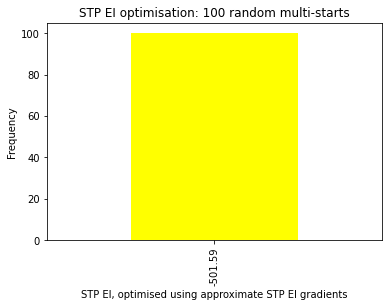

In [50]:
ax = approx_15_100rms.plot.bar(title="STP EI optimisation: 100 random multi-starts", xlabel="STP EI, optimised using approximate STP EI gradients", ylabel="Frequency", color="yellow")


In [51]:
exact_15_100rms = pd.Series(np.round(exact_15_100rms.f_best, 2)).value_counts(sort=True)
exact_15_100rms_df = pd.DataFrame({'Frequency':exact_15_100rms.values,'STP EI':exact_15_100rms.index})
exact_15_100rms_df


,Frequency,STP EI
0,79,-501.59
1,12,-501.58
2,2,-501.56
3,1,-501.49
4,1,-486.72
5,1,-486.97
6,1,-501.55
7,1,-484.83
8,1,-487.69
9,1,-501.54


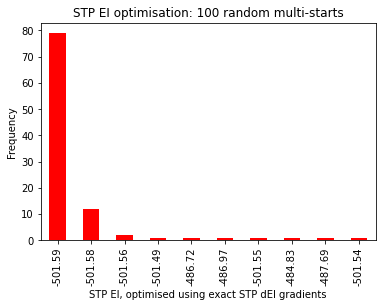

In [52]:
ax = exact_15_100rms.plot.bar(title="STP EI optimisation: 100 random multi-starts", xlabel="STP EI, optimised using exact STP dEI gradients", ylabel="Frequency", color="red")


In [53]:
print(approx_15_20rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-501.59 &  20 \\
\bottomrule
\end{tabular}



In [54]:
print(exact_15_20rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-501.59 &  15 \\
-501.58 &   4 \\
-501.49 &   1 \\
\bottomrule
\end{tabular}



In [55]:
print(approx_15_50rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-501.59 &  50 \\
\bottomrule
\end{tabular}



In [56]:
print(exact_15_50rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-501.59 &  40 \\
-501.58 &   6 \\
-501.49 &   1 \\
-486.72 &   1 \\
-501.56 &   1 \\
-486.97 &   1 \\
\bottomrule
\end{tabular}



In [57]:
print(approx_15_100rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &    0 \\
\midrule
-501.59 &  100 \\
\bottomrule
\end{tabular}



In [58]:
print(exact_15_100rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-501.59 &  79 \\
-501.58 &  12 \\
-501.56 &   2 \\
-501.49 &   1 \\
-486.72 &   1 \\
-486.97 &   1 \\
-501.55 &   1 \\
-484.83 &   1 \\
-487.69 &   1 \\
-501.54 &   1 \\
\bottomrule
\end{tabular}

